In [10]:
import torch
from torchvision.transforms import v2 as transforms

from keyrover import *
from keyrover.datasets import *
from keyrover.vision import *
from keyrover.ml import get_device, BinarySegmentationModel
from keyrover.math import quad_area

In [2]:
device = get_device()

In [3]:
image_paths = get_dataset_paths()
train_paths, test_paths, valid_paths = split_train_test_valid(image_paths, 0.95, 0.1)

SIZE = (480, 640)
test_dataset = BinaryKeyboardSegmentationDataset(test_paths, size=SIZE)

len(test_dataset)

  0%|          | 0/101 [00:00<?, ?it/s]

101

In [5]:
mean, std = get_dataset_norm_params(version=3)

transform = transforms.Compose([
    transforms.ToImage(),
    transforms.Resize(SIZE),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(mean, std),
])

test_dataset.set_augmentations([
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(mean, std),
])

In [6]:
ARCH = "unetplusplus"
BACKBONE = "resnet18"
name = "jumping-darkness-67"

LEARNING_RATE = None

model = BinarySegmentationModel(ARCH, BACKBONE, in_channels=3, out_classes=1, lr=None)
model.load_state_dict(torch.load(f"models/binary_segmentation/{name}-{ARCH}-{BACKBONE}-v3.pt", weights_only=True))
model.eval()
model.to(device)

BinarySegmentationModel(
  (model): UnetPlusPlus(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


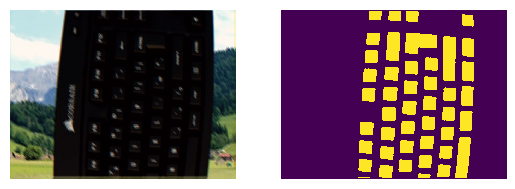

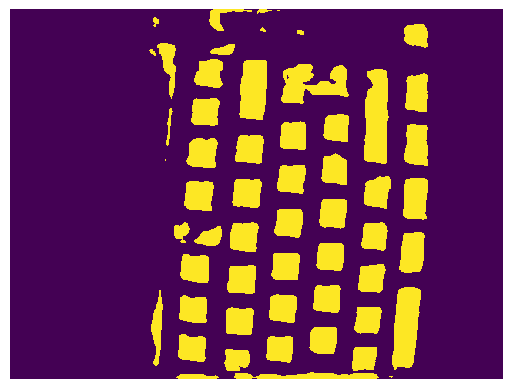

In [7]:
img, mask = test_dataset.random_img()
pred = model.predict(img)

imshow(img, mask)
imshow(pred > 1)

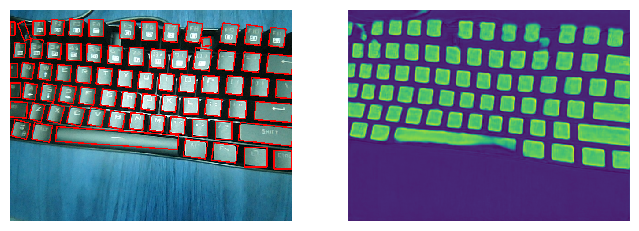

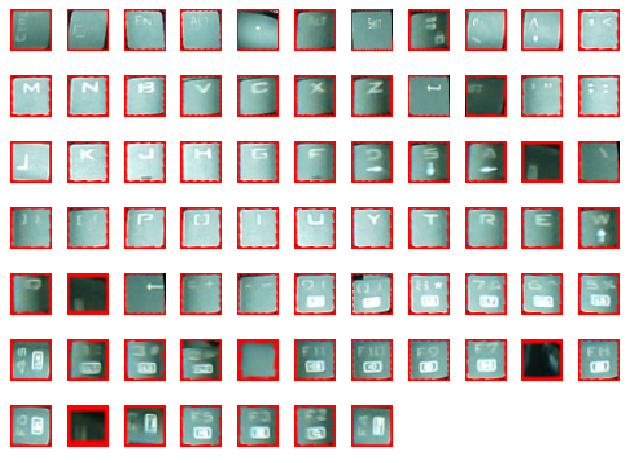

In [11]:
img = cv2.imread(f"datasets/test/1.jpg")

pred = model.predict(transform(img))
mask = pred > 0

keys = []
for rect in extract_rotated_rects(mask):
    if quad_area(rect) < 300:
        continue
    cv2.drawContours(img, [rect], -1, (255, 0, 0), 2)

    crop = crop_rect(img, rect)
    crop = cv2.resize(crop, (32, 32))
    keys.append(crop)

imshow(img, pred, figsize=(8, 8))
show_images(keys)